<a href="https://colab.research.google.com/github/BenjaminLovelady/Notebooks/blob/test/UKF_10d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generic UKF library stuff:

In [5]:
import numpy as np
from scipy.linalg import cholesky

def unscented_transform(sigma_points, weights):
    mean = np.sum(weights * sigma_points.T, axis=1)

    # Ensure mean has a column shape for proper broadcasting
    mean_col = mean[:, np.newaxis]

    sigma_points_centered = np.zeros_like(sigma_points)
    for i in range(len(sigma_points)):
        sigma_points_centered[i] = sigma_points[i] - mean_col.flatten()

    covariance = np.zeros((len(mean), len(mean)))
    for i in range(len(sigma_points)):
        covariance += weights[i] * np.outer(sigma_points_centered[i], sigma_points_centered[i])

    return mean, covariance


def generate_sigma_points(mean, covariance, processNoise, alpha=1e-3, beta=2, kappa=0):
    n = len(mean)
    sigma_points = np.zeros((2 * n + 1, n))

    covariance += processNoise

    lambda_ = alpha**2 * (n + kappa) - n
    sqrt_cov = cholesky((n + lambda_) * covariance, lower=True)

    sigma_points[0] = mean
    for i in range(n):
        sigma_points[i + 1] = mean + sqrt_cov[i]
        sigma_points[i + n + 1] = mean - sqrt_cov[i]

    return sigma_points


def predict(current_state, current_covariance, process_model, controlInput, processNoise, alpha, beta, kappa, dt):

    sigma_points = generate_sigma_points(current_state, current_covariance, processNoise, alpha, beta, kappa)
    sigma_points_pred = np.array([process_model(sigPoint, controlInput, dt) for sigPoint in sigma_points])

    return sigma_points_pred


def update(sigma_points_pred, measurement_model, measurementNoise, measurement, weights):

    mean_pred, covariance_pred = unscented_transform(sigma_points_pred, weights)

    measurement_pred_sig = np.array([measurement_model(p) for p in sigma_points_pred])

    meas_pred_mean, meas_pred_covariance = unscented_transform(measurement_pred_sig, weights)
    meas_pred_covariance += measurementNoise

    n = len(sigma_points_pred[0])
    cross_covariance = np.zeros((n, len(meas_pred_mean)))
    for i in range(2 * n + 1):
        cross_covariance += weights[i] * np.outer(sigma_points_pred[i] - mean_pred, measurement_pred_sig[i] - meas_pred_mean)

    kalman_gain = cross_covariance @ np.linalg.inv(meas_pred_covariance)

    state_mean = mean_pred + kalman_gain @ (measurement - meas_pred_mean)
    state_covariance = covariance_pred - kalman_gain @ meas_pred_covariance @ kalman_gain.T

    return state_mean, state_covariance



Now define the model for predicting and measuring. For this we need to think about the state:


For the kite motion, we have a few things we care about:

1. Kite attitude (orientation)
2. Kite location (relative to pilot)
3. Kite motion (velocity)

The complementay filter for determining orientation is working well, so we'll do that first and not bother with any orientation derivatives.

We do need linear velocities though, but these will blow up if we're not careful, so we want to constrain it somehow. Perhaps by using the orientation...

The stationary state vector would look like:

$$ \vec{x} = \left(\begin{array}{c}
q_0\\
q_1\\
q_2\\
q_3\\
x\\
y\\
z\\
\dot x\\
\dot y\\
\dot z\\
\end{array}\right)$$

The update step will be something like:

1. Find the orientation from IMU
2. Calc COM from orientation
now measurement is a vector
$$ \vec{m} = \left(\begin{array}{c}
q_0\\
q_1\\
q_2\\
q_3\\
x\\
y\\
z\\
\end{array}\right)$$

The predict step will look like:
1. Integrate from globalAccel to get velocity/accel
2. Nudge above horizon
3. Normalize the vector to make sure kite is still 22m away


This makes the controlInput for the process model simply the global acceleration.


The measurement model will take the quaterion and use it to calculate COM

In [6]:

def process_model(state, controlInput, dt):

    #control input for this is the accelerometer readings in m/s^2, aligned with global axes
    ax, ay, az = controlInput
    qw, qx, qy, qz, x, y, z, vx, vy, vz = state

    dtSq_half = 0.5*dt**2

    x_pred = x + vx * dt + ax * dtSq_half
    y_pred = y + vy * dt + ay * dtSq_half
    z_pred = z + vz * dt + az * dtSq_half
    vx_pred = vx + ax * dt
    vy_pred = vy + ay * dt
    vz_pred = vz + az * dt

    if z_pred < 0:
      z_pred += 0.1
      vz_pred += 0.1

    kiteDistance = 22
    normalizeFactor = 22/np.sqrt(x_pred**2+y_pred**2+z_pred**2)

    return np.array([qw, qx, qy, qz, x_pred*normalizeFactor, y_pred*normalizeFactor, z_pred*normalizeFactor, vx_pred, vy_pred, vz_pred])

def measurement_model(state):
    qw, qx, qy, qz, x, y, z, vx, vy, vz = state

    return [qw, qx, qy, qz, x, y, z]


Pull in some test data

In [7]:
stateDimensionality = 10

# Define weights for unscented transform
alpha = 1e-3
beta = 2
kappa = 0
weights = np.zeros(2 *stateDimensionality + 1)
weights[0] = kappa / (stateDimensionality + kappa)
weights[1:] = 1 / (2 * (stateDimensionality + kappa))

# Define the noise covariance, not sure what to do, so I'll just use small diag values
measurement_noise_covariance = np.array([[1e-6,0,0,0],
                                         [0,1e-6,0,0],
                                         [0,0,1e-6,0],
                                          [0,0,0,1e-6]])

process_noise_covariance = np.array([[1e-6,0,0,0,0,0,0,0,0,0],
                                      [0,1e-6,0,0,0,0,0,0,0,0],
                                      [0,0,1e-6,0,0,0,0,0,0,0],
                                      [0,0,0,1e-6,0,0,0,0,0,0],
                                      [0,0,0,0,1e-6,0,0,0,0,0],
                                      [0,0,0,0,0,1e-6,0,0,0,0],
                                      [0,0,0,0,0,0,1e-6,0,0,0],
                                      [0,0,0,0,0,0,0,1e-6,0,0],
                                      [0,0,0,0,0,0,0,0,1e-6,0],
                                      [0,0,0,0,0,0,0,0,0,1e-6]])




In [8]:
# quaternion methods
def quatMult(q1, q2):
    w = q1[0]*q2[0]-q1[1]*q2[1]-q1[2]*q2[2]-q1[3]*q2[3]
    x = q1[0]*q2[1]+q1[1]*q2[0]+q1[2]*q2[3]-q1[3]*q2[2]
    y = q1[0]*q2[2]-q1[1]*q2[3]+q1[2]*q2[0]+q1[3]*q2[1]
    z = q1[0]*q2[3]+q1[1]*q2[2]-q1[2]*q2[1]+q1[3]*q2[0]

    return [w,x,y,z]

def quatConj(q):
    return[q[0],-q[1],-q[2],-q[3]]

def magnitude(q):
    return numpy.sqrt(q[0]*q[0]+q[1]*q[1]+q[2]*q[2]+q[3]*q[3])

def dot(q1, q2):
    return q1[0]*q2[0]+q1[1]*q2[1]+q1[2]*q2[2]+q1[3]*q2[3]

def mult(q1, a):
    w = q1[0]*a
    x = q1[1]*a
    y = q1[2]*a
    z = q1[3]*a
    return [w,x,y,z]

def plus(q1, q2):
    w = q1[0]+q2[0]
    x = q1[1]+q2[1]
    y = q1[2]+q2[2]
    z = q1[3]+q2[3]

    return [w,x,y,z]

def quatRot(q, v):
  # q * v * q^-1
  x,y,z = v
  v_q = [0,x,y,z]

  new = quatMult(q, quatMult(v_q,quatConj(q)))
  w_, x_, y_, z_ = new
  return [x_,y_,z_]

In [9]:
import csv

globAccel = []
quats = []

with open('quats.csv') as f:
  reader = csv.reader(f)
  mdata = [row for row in reader]
  mdata = mdata[1:len(mdata)-1]
  quats = [[float(v) for v in row] for row in mdata]

with open('accel.csv') as g:
  reader = csv.reader(g)
  ndata = [row for row in reader]
  ndata = ndata[1:len(ndata)-1]
  accel = [[float(v) for v in row] for row in ndata]


initialKiteVector = [0,0,-22]
coms = [[0,0,0,0]]
measurements = []

for i in range(len(quats)):
  t,qw,qx,qy,qz = quats[i]
  com = quatRot([w,x,y,z],initialKiteVector)
  x,y,z = com
  coms.append([t, x, y, z])
  measurements.append[t,qw,qx,qy,qz,x,y,z]


lastAccelIndex = 0
def getCurrentAccel(time):

  while(lastAccelIndex < len(accel)):
    acc = accel[lastAccelIndex]
    if acc[0] >= time:
      return acc
    lastAccelIndex += 1


FileNotFoundError: [Errno 2] No such file or directory: 'quats.csv'

In [ ]:

# Define initial state and covariance

current_state = [1,0,0,0,0,0,-22,0,0,0]
current_covariance = np.eye(10)

filteredMeasurements = []

dt = 0.005
count = 0

for measurement in measurements:

  t,qw,qx,qy,qz,x,y,z = measurement

  #both are from IMU, so no need to run things separately
  currentAccel = getCurrentAccel(t)

  sigma_pred = predict(current_state, current_covariance, process_model, currentAccel, process_noise_covariance, alpha, beta, kappa, dt)

  current_state, current_covariance = update(sigma_pred, measurement_model, measurement_noise_covariance, [qw,qx,qy,qz,x,y,z], weights)

  if count % 20 == 0:
    blahhhh = [t, current_state[0],current_state[1],current_state[2]]
    filteredMeasurements.append(blahhhh)
    if len(filteredMeasurements) > 8000: break




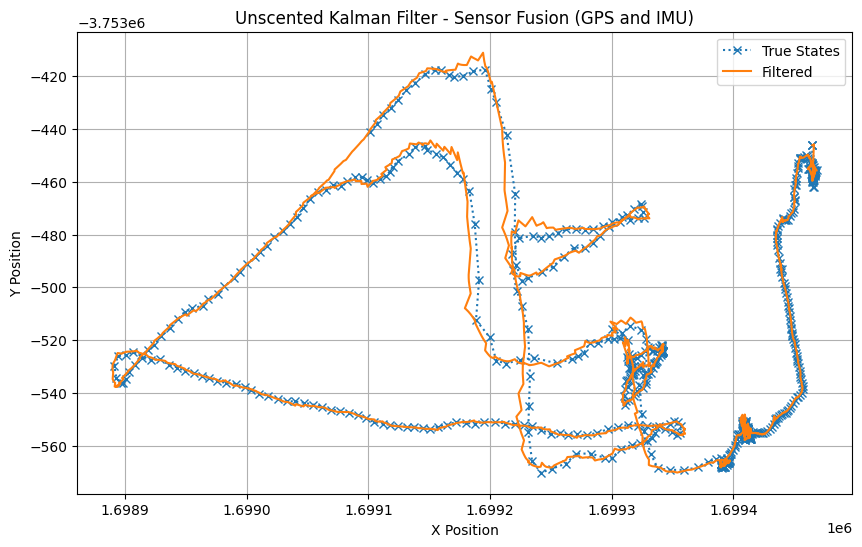

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.plot([s[1] for s in gps[:800]], [s[2] for s in gps[:800]], label='True States', linestyle=':', marker='x')
# plt.plot([s[0] for s in measurements], [s[1] for s in measurements], label='Measurements', marker='o')
plt.plot([s[1] for s in filteredMeasurements], [s[2] for s in filteredMeasurements], label='Filtered')
# plt.plot(filteredMeasurements[:, 0], filteredMeasurements[:, 1], label='Filtered')

# plt.plot([m[0] for m in measurements], [m[1] for m in measurements], label="Measurements")
# plt.plot([s[0] for s in trueStates], [s[1] for s in trueStates], label="True states")
# plt.legend()
# plt.show()

plt.title('Unscented Kalman Filter - Sensor Fusion (GPS and IMU)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()

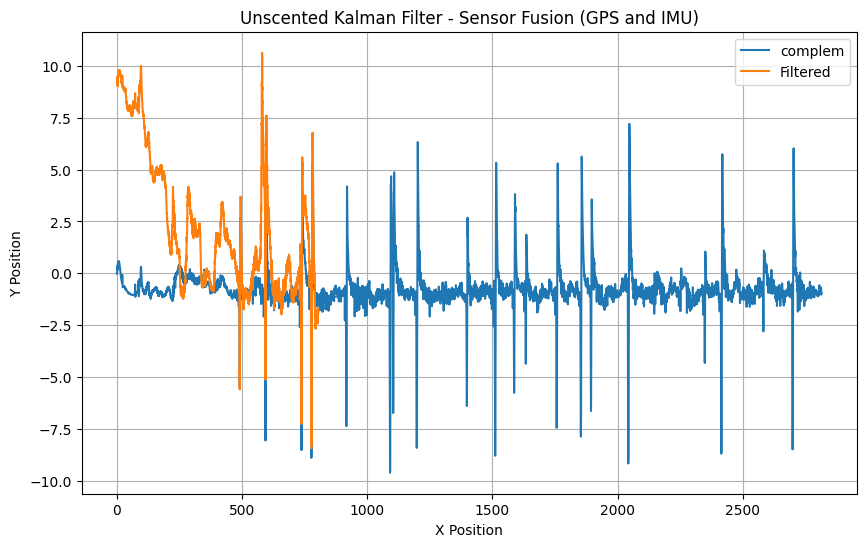

In [ ]:
# Plotting the results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# plt.plot([s[0] for s in gps], [s[3] for s in gps], label='True States', linestyle=':',)
# plt.plot([s[0] for s in measurements], [s[1] for s in measurements], label='Measurements', marker='o')
plt.plot([s[0] for s in complem], [s[1] for s in complem], label='complem')
plt.plot([s[0] for s in filteredMeasurements], [s[3] for s in filteredMeasurements], label='Filtered')

# plt.plot(filteredMeasurements[:, 0], filteredMeasurements[:, 1], label='Filtered')

# plt.plot([m[0] for m in measurements], [m[1] for m in measurements], label="Measurements")
# plt.plot([s[0] for s in trueStates], [s[1] for s in trueStates], label="True states")
# plt.legend()
# plt.show()

plt.title('Unscented Kalman Filter - Sensor Fusion (GPS and IMU)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend()
plt.grid(True)
plt.show()